In [179]:
# Run on GPU server
# import os
# os.chdir('/root/autodl-tmp/FinanceTech/')

In [180]:
import pickle
import pandas as pd
from codes.nn_utils import *
from codes.backtest import show_back_test
import lightgbm as lgb
from scipy.stats import pearsonr

In [181]:
with open("factors/factor_df_list.pkl", "rb") as f:
    X = pickle.load(f)
with open("factors/y.pkl", "rb") as f:
    y = pickle.load(f)
print(len(X), " ", X[0].shape)
print(y.shape)

100   (1369, 503)
(1369, 503)


In [182]:
# 数据清洗
X, y = fill_na(X, y)

In [183]:
y

stk_id,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
trade_date,,,,,,,,,,,,,,,,,,,,,
2017-11-01,0.001719,-0.010248,0.013731,0.008045,-0.021499,-0.050394,0.008139,-0.025445,0.003768,0.026610,...,-0.010449,0.000000,-0.005230,0.000000,0.015002,0.075472,-0.025225,-0.009405,0.016175,0.047138
2017-11-02,0.003745,0.001941,0.001585,0.029263,0.019960,0.024577,0.024002,-0.009122,0.004871,0.007516,...,0.000282,0.000000,-0.005412,0.061821,-0.007958,-0.003480,-0.028681,0.014463,-0.001011,0.022186
2017-11-03,-0.002332,0.001292,-0.015681,0.011372,0.009860,0.000917,-0.009802,0.011111,-0.000874,-0.008228,...,0.009149,0.000000,0.008862,-0.014875,-0.000491,0.013968,0.000866,0.012770,-0.009105,0.016043
2017-11-06,0.000467,-0.022576,-0.019439,0.003578,0.015022,0.000763,0.003228,0.000628,-0.003420,0.000442,...,0.005579,0.000000,-0.002620,0.008281,0.001147,0.016358,-0.005958,-0.055963,-0.040071,-0.019505
2017-11-07,-0.002180,-0.001980,0.000447,0.009167,0.025899,0.001525,0.001931,-0.001569,0.011094,0.017581,...,0.004161,0.000000,-0.001700,0.002093,-0.000982,0.001694,0.004350,-0.024700,-0.009040,0.018314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-05,-0.000434,0.008639,0.004043,0.005496,0.004708,-0.006035,0.006943,0.005103,0.001320,-0.003717,...,0.004788,0.002109,-0.016583,0.007902,-0.000100,0.001213,0.004510,0.000366,0.026546,0.007712
2023-04-06,-0.000072,0.009993,-0.002517,-0.015972,-0.001687,0.000180,-0.011779,-0.004207,-0.000071,-0.011429,...,0.007331,-0.007156,-0.004433,0.006070,0.012867,-0.007570,-0.007897,0.005662,0.016332,0.011449
2023-04-10,0.003623,0.012014,0.015056,-0.007591,0.000626,0.001022,-0.003973,0.005244,0.016574,-0.013661,...,-0.017649,0.003957,0.007072,0.024887,0.011620,0.003585,0.025205,0.006855,0.008035,0.001994


In [184]:
# 将X拼接起来
X_ = []
for i, x in enumerate(X):
    X_.append(x.stack().reset_index().rename(columns={0:f"fac{i}"}))
def merge_dataframes(df_list):
    result_df = pd.DataFrame()  # 创建空的结果DataFrame
    for df in df_list:
        if result_df.empty:  # 如果结果DataFrame为空，直接将当前DataFrame赋值给结果DataFrame
            result_df = df
        else:
            result_df = pd.merge(result_df, df, on=['stk_id', 'trade_date'], how='outer')  # 拼接当前DataFrame与结果DataFrame

    return result_df
X_ = merge_dataframes(X_)
y_ = y.stack().reset_index().rename(columns={0:"y"})

In [185]:
y_

,trade_date,stk_id,y
0,2017-11-01,A,0.001719
1,2017-11-01,AAL,-0.010248
2,2017-11-01,AAP,0.013731
3,2017-11-01,AAPL,0.008045
4,2017-11-01,ABBV,-0.021499
...,...,...,...
688602,2023-04-12,YUM,0.020306
688603,2023-04-12,ZBH,0.007067
688604,2023-04-12,ZBRA,0.015792
688605,2023-04-12,ZION,0.028392


In [204]:
# 分割数据
# 根据train, test, val的比例分割数据集
train_prop = 0.6
test_prop = 0.2
valid_prop = 0.2
train_X = X_[: int(len(X_) * train_prop)].drop(columns=["stk_id", "trade_date"])
train_y = y_[: int(len(y_) * train_prop)].drop(columns=["stk_id", "trade_date"])
test_X = X_[int(len(X_) * train_prop): int(len(X_) * (train_prop+test_prop))].drop(columns=["stk_id", "trade_date"])
test_y = y_[int(len(y_) * train_prop): int(len(y_) * (train_prop+test_prop))].drop(columns=["stk_id", "trade_date"])
valid_X = X_[int(len(X_) * (train_prop+test_prop)): ].drop(columns=["stk_id", "trade_date"])
valid_y = y_[int(len(y_) * (train_prop+test_prop)): ].drop(columns=["stk_id", "trade_date"])

In [187]:
# 创建训练和验证的数据集
train_dataset = lgb.Dataset(train_X, label=train_y)
test_dataset = lgb.Dataset(test_X, label=test_y)
valid_dataset = lgb.Dataset(valid_X, label=valid_y)

In [188]:
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

In [189]:
# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    # 'metric': "valid_1's pearsonr",
    'num_leaves': 64,
    'learning_rate': 0.05,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.96,
    'bagging_freq': 5,
    # 'bagging_freq': 1,
    # 'verbose': 0,
    'verbosity': -1,
    'n_jobs': -1,
    'seed': 29,
    'lambda_l1': 1,
    'lambda_l2': 1e-08,

    'max_depth': 6,
    'max_bin': 400,
    'min_data_in_leaf': 400
}

In [190]:
# 训练模型
num_round = 500  # 训练轮数
callbacks = [lgb.early_stopping(stopping_rounds=50, first_metric_only=True),
             lgb.log_evaluation(period=5)]
gbm = lgb.train(params,
                num_boost_round=num_round,
                train_set = train_dataset,
                valid_sets = [train_dataset, valid_dataset],
                verbose_eval=5,
                feval = feval_pearsonr,
                callbacks=callbacks
                )

Training until validation scores don't improve for 50 rounds
[5]	training's l2: 0.000609576	training's pearsonr: 0.0934208	valid_1's l2: 0.000521913	valid_1's pearsonr: 0.0142845
[5]	training's l2: 0.000609576	training's pearsonr: 0.0934208	valid_1's l2: 0.000521913	valid_1's pearsonr: 0.0142845
[10]	training's l2: 0.000608377	training's pearsonr: 0.0983548	valid_1's l2: 0.000521863	valid_1's pearsonr: 0.0155657
[10]	training's l2: 0.000608377	training's pearsonr: 0.0983548	valid_1's l2: 0.000521863	valid_1's pearsonr: 0.0155657
[15]	training's l2: 0.000607558	training's pearsonr: 0.0998553	valid_1's l2: 0.000521811	valid_1's pearsonr: 0.0185245
[15]	training's l2: 0.000607558	training's pearsonr: 0.0998553	valid_1's l2: 0.000521811	valid_1's pearsonr: 0.0185245
[20]	training's l2: 0.000606811	training's pearsonr: 0.104144	valid_1's l2: 0.000521792	valid_1's pearsonr: 0.0183118
[20]	training's l2: 0.000606811	training's pearsonr: 0.104144	valid_1's l2: 0.000521792	valid_1's pearsonr: 0

In [203]:
# 保存gbm模型
with open("models/lgb.pkl", "wb") as f:
    pickle.dump(gbm, f)

In [192]:
# 加载gbm模型
# with open("models/lgb.pkl", "rb") as f:
#     gbm = pickle.load(f)

In [205]:
# 预测
y_train_pred = gbm.predict(train_X, num_iteration=gbm.best_iteration)
y_test_pred = gbm.predict(test_X, num_iteration=gbm.best_iteration)
y_valid_pred = gbm.predict(valid_X, num_iteration=gbm.best_iteration)

In [194]:
with open("data/gbm_y_train_pred.pkl", "wb") as f:
    pickle.dump(y_train_pred, f)
with open("data/gbm_y_test_pred.pkl", "wb") as f:
    pickle.dump(y_test_pred, f)
with open("data/gbm_y_valid_pred.pkl", "wb") as f:
    pickle.dump(y_valid_pred, f)

In [209]:
train_y_ = pd.concat([y_[: int(len(y_) * train_prop)][["trade_date", "stk_id"]], train_y], axis=1)
train_y_ = train_y_.pivot(index="trade_date", columns="stk_id", values=["y"])["y"]
print(train_y_.shape)
test_y_ = pd.concat([y_[int(len(y_) * train_prop): int(len(y_) * (train_prop+test_prop))][["trade_date", "stk_id"]], test_y], axis=1)
test_y_ = test_y_.pivot(index="trade_date", columns="stk_id", values=["y"])["y"]
valid_y_ = pd.concat([y_[int(len(y_) * (train_prop+test_prop)): ][["trade_date", "stk_id"]], valid_y], axis=1)
valid_y_ = valid_y_.pivot(index="trade_date", columns="stk_id", values=["y"])["y"]

(822, 503)


In [210]:
y_train_pred_ = pd.concat([
    y_[: int(len(y_) * train_prop)][["trade_date", "stk_id"]],
    pd.DataFrame(y_train_pred, columns=["y_pred"])
], axis=1)
y_train_pred_ = y_train_pred_.pivot(index="trade_date", columns="stk_id", values=["y_pred"])["y_pred"]

temp1 = y_[int(len(y_) * train_prop): int(len(y_) * (train_prop+test_prop))][["trade_date", "stk_id"]]
temp1 = temp1.reset_index(drop=True)
y_test_pred_ = pd.concat([temp1,
    pd.DataFrame(y_test_pred, columns=["y_pred"])
], axis=1)
y_test_pred_ = y_test_pred_.pivot(index="trade_date", columns="stk_id", values=["y_pred"])["y_pred"]

temp1 = y_[int(len(y_) * (train_prop+test_prop)): ][["trade_date", "stk_id"]]
temp1 = temp1.reset_index(drop=True)
y_valid_pred_ = pd.concat([temp1, pd.DataFrame(y_valid_pred, columns=["y_pred"])], axis=1)
y_valid_pred_ = y_valid_pred_.pivot(index="trade_date", columns="stk_id", values=["y_pred"])["y_pred"]

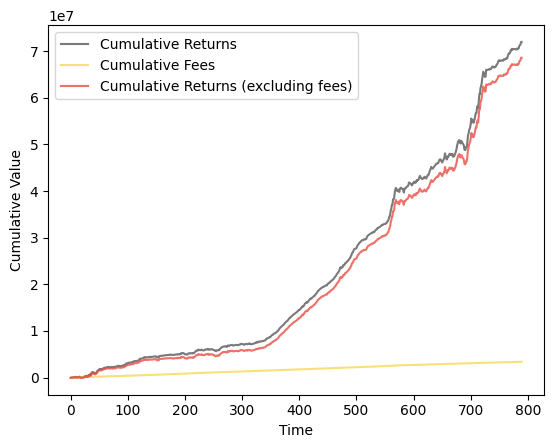

returns    : 1.0938         
ir         : 0.3786         
sharpe     : 6.0094         
turnover   : 0.1074         
draw_down  : 2507381.3104   


In [211]:
show_back_test(train_y_.values, y_train_pred_.values, decay=32)

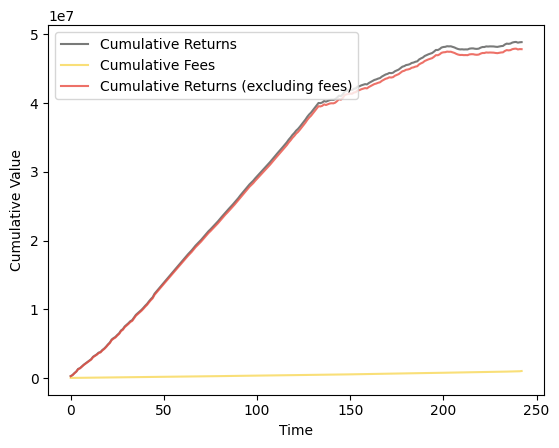

returns    : 2.4815         
ir         : 1.4672         
sharpe     : 23.2913        
turnover   : 0.1055         
draw_down  : 640173.5209    


In [201]:
show_back_test(test_y_.values, y_test_pred_.values, decay=32)

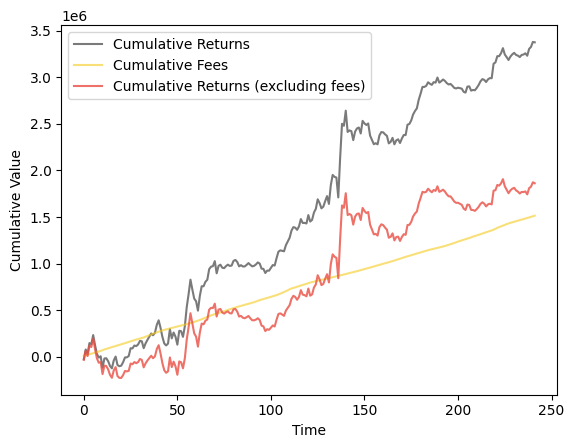

returns    : 0.0970         
ir         : 0.1089         
sharpe     : 1.7285         
turnover   : 0.1564         
draw_down  : 657298.7275    


In [200]:
show_back_test(valid_y_.values, y_valid_pred_.values, decay=32)